# **CARGA DE DATOS Y DE LIBRERÍAS**

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os

# Ruta inicial en Google Drive
drive_root = '/content/drive/My Drive/'

# Función para encontrar la ruta completa de un archivo específico
def find_file_in_drive(filename, drive_root='/content/drive/My Drive/'):
    for root, dirs, files in os.walk(drive_root):
        if filename in files:
            return os.path.join(root, filename)
    return None

# Ejemplo: encontrar la ruta de 'archivo1.zip' y 'archivo2.zip'
zip1_path = find_file_in_drive('Brain_Tumor_Synthetic (1).zip')
zip2_path = find_file_in_drive('Healthy_Synthetic (1).zip')

print('Ruta de Brain_Tumor_Synthetic.zip:', zip1_path)
print('Ruta de Healthy_Synthetic.zip:', zip2_path)


Ruta de Brain_Tumor_Synthetic.zip: /content/drive/My Drive/Brain_Tumor_Synthetic (1).zip
Ruta de Healthy_Synthetic.zip: /content/drive/My Drive/Healthy_Synthetic (1).zip


In [4]:
from google.colab import drive
import os
import shutil
from zipfile import ZipFile

# Crear la carpeta Brain Images en /content si no existe
base_folder = '/content/Brain Sintetic Images'
os.makedirs(base_folder, exist_ok=True)

# Crear subcarpetas para Brain Tumor y Healthy
brain_tumor_folder = os.path.join(base_folder, 'Brain Tumor')
healthy_folder = os.path.join(base_folder, 'Healthy')

os.makedirs(brain_tumor_folder, exist_ok=True)
os.makedirs(healthy_folder, exist_ok=True)

# Rutas a los archivos ZIP en Google Drive
zip1_path = '/content/drive/My Drive/Brain_Tumor_Synthetic (1).zip'
zip2_path = '/content/drive/My Drive/Healthy_Synthetic (1).zip'

# Copiar los archivos ZIP a /content/Brain Images
shutil.copy(zip1_path, base_folder)
shutil.copy(zip2_path, base_folder)

# Extraer los archivos ZIP en las subcarpetas correspondientes
with ZipFile(os.path.join(base_folder, 'Brain_Tumor_Synthetic (1).zip'), 'r') as zip_ref:
    zip_ref.extractall(brain_tumor_folder)

with ZipFile(os.path.join(base_folder, 'Healthy_Synthetic (1).zip'), 'r') as zip_ref:
    zip_ref.extractall(healthy_folder)

# Eliminar los archivos ZIP después de extraerlos (opcional)
os.remove(os.path.join(base_folder, 'Brain_Tumor_Synthetic (1).zip'))
os.remove(os.path.join(base_folder, 'Healthy_Synthetic (1).zip'))

print(f'Imágenes de tumor cerebral extraídas en: {brain_tumor_folder}')
print(f'Imágenes saludables extraídas en: {healthy_folder}')

Imágenes de tumor cerebral extraídas en: /content/Brain Sintetic Images/Brain Tumor
Imágenes saludables extraídas en: /content/Brain Sintetic Images/Healthy


In [5]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
import glob


# **PROCESAMIENTO DE LOS DATOS**

In [6]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Redimensionar las imágenes a un tamaño uniforme
            images.append(img)
            labels.append(label)
    return images, labels

# Rutas a los datasets
tumor_path = '/content/Brain Sintetic Images/Brain Tumor'
non_tumor_path = '/content/Brain Sintetic Images/Healthy'

In [7]:
base_dir = '/content/Brain Sintetic Images'

In [8]:
# Cargar imágenes y etiquetas de cada categoría
tumor_images, tumor_labels = load_images_from_folder(tumor_path, 1)  # 1 para Tumor
non_tumor_images, non_tumor_labels = load_images_from_folder(non_tumor_path, 0)  # 0 para Healthy

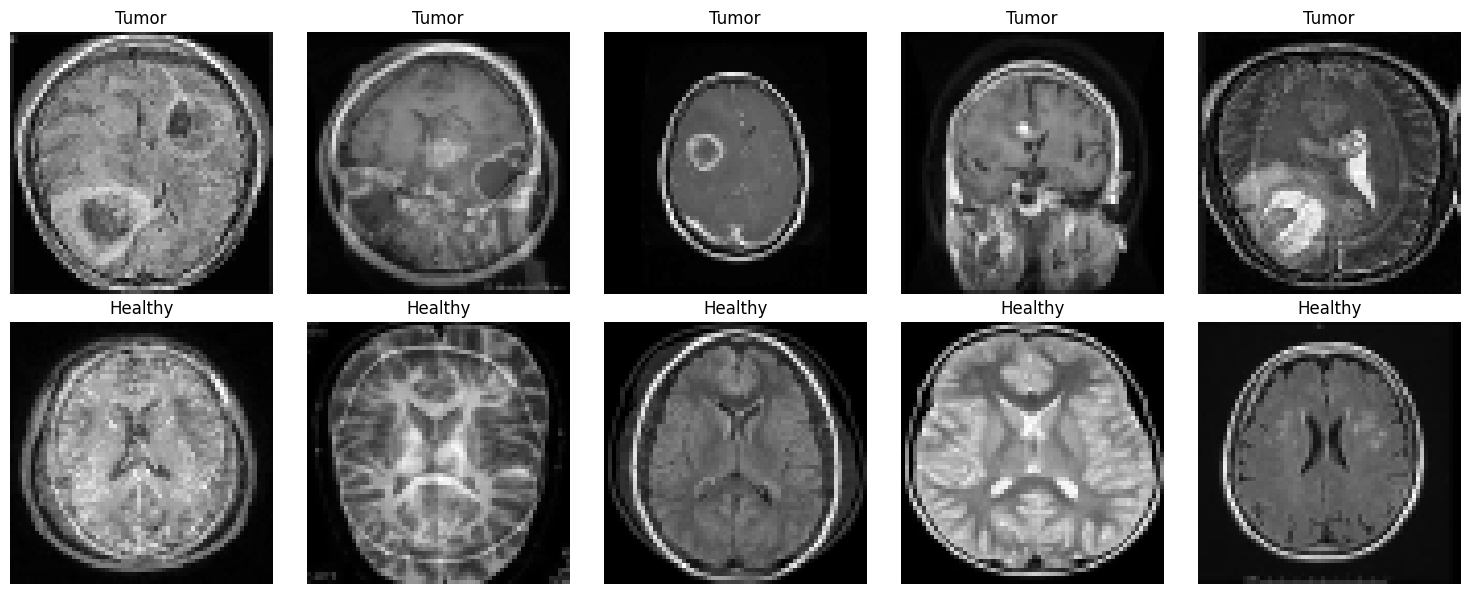

In [9]:
# Display images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows of images, 5 columns

# Ensure that the axes object is a 2D array
if len(tumor_images) < 5 or len(non_tumor_images) < 5:
    raise ValueError("Not enough images loaded for displaying.")

# Display tumor images
for i in range(5):
    ax = axes[0, i]  # Select the subplot
    ax.imshow(tumor_images[i], cmap='gray')
    ax.set_title('Tumor')
    ax.axis('off')

# Display non-tumor images
for i in range(5):
    ax = axes[1, i]  # Select the subplot
    ax.imshow(non_tumor_images[i], cmap='gray')
    ax.set_title('Healthy')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Combinar datasets
images = np.array(tumor_images + non_tumor_images)
labels = np.array(tumor_labels + non_tumor_labels)

# Normalizar los valores de los píxeles
images = images / 255.0

# Redimensionar las imágenes para la entrada de la CNN
images = images.reshape(-1, 64, 64, 1)

In [11]:
# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [12]:
# Convertir imágenes a RGB para usar modelo preentrenado (VGG16 espera 3 canales de color)
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

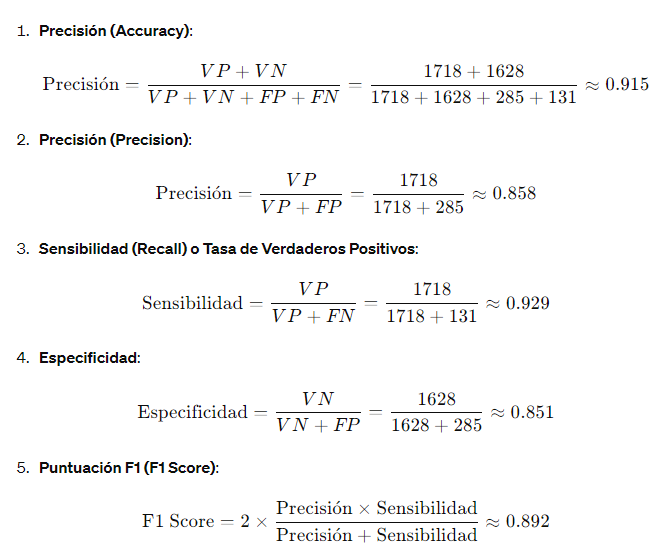

In [13]:
# Crear un generador de datos con aumento de datos
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [14]:
# Define the CNN architecture
model2 = Sequential([
    Input(shape=(64,64,3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Using sigmoid for binary classification
])

model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con aumento de datos
history2 = model2.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=20,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


Epoch 1/20
500/500 [==============================] - 41s 63ms/step - loss: 0.6141 - accuracy: 0.6606 - val_loss: 0.5067 - val_accuracy: 0.7592
Epoch 2/20
500/500 [==============================] - 28s 56ms/step - loss: 0.5168 - accuracy: 0.7474 - val_loss: 0.4023 - val_accuracy: 0.8242
Epoch 3/20
500/500 [==============================] - 24s 47ms/step - loss: 0.4352 - accuracy: 0.8004 - val_loss: 0.3429 - val_accuracy: 0.8645
Epoch 4/20
500/500 [==============================] - 23s 46ms/step - loss: 0.3651 - accuracy: 0.8438 - val_loss: 0.2385 - val_accuracy: 0.9060
Epoch 5/20
500/500 [==============================] - 25s 50ms/step - loss: 0.2951 - accuracy: 0.8784 - val_loss: 0.2055 - val_accuracy: 0.9187
Epoch 6/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2492 - accuracy: 0.8999 - val_loss: 0.1659 - val_accuracy: 0.9365
Epoch 7/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2184 - accuracy: 0.9127 - val_loss: 0.1331 - val_accuracy:

In [16]:
hist_=pd.DataFrame(history2.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.614117,0.660563,0.506736,0.75925
1,0.516847,0.747375,0.402341,0.82425
2,0.435213,0.800438,0.342907,0.86450
3,0.365130,0.843813,0.238540,0.90600
4,0.295134,0.878375,0.205513,0.91875
5,0.249162,0.899938,0.165939,0.93650
6,0.218437,0.912687,0.133054,0.95675
7,0.206925,0.918187,0.145164,0.94100
8,0.189281,0.926813,0.105383,0.96450
9,0.174719,0.930812,0.131871,0.94650


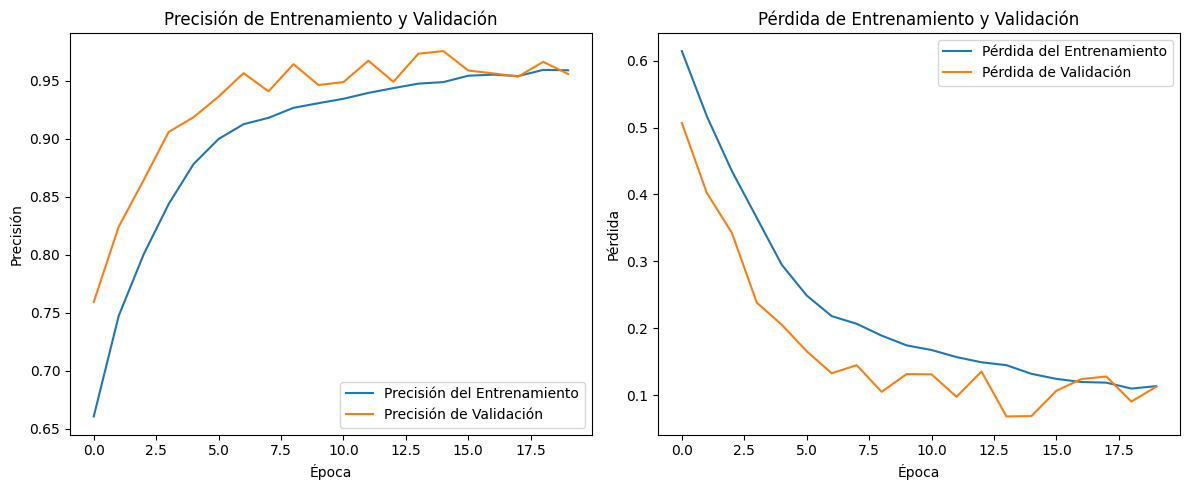

In [17]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history2.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Realizar predicciones con salida detallada
y_pred_prob = model2.predict(X_test, verbose=1)

# Convertir probabilidades en etiquetas binarias basadas en un umbral de 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# Crear un DataFrame para mostrar etiquetas reales y predichas
results = pd.DataFrame({
    'Etiqueta Actual': y_test.flatten(),  # Ajustar según la forma de tus etiquetas reales
    'Etiqueta Predicha': y_pred.flatten()
})

# Convertir las etiquetas a "Healthy" y "Tumor"
results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Healthy', 1: 'Tumor'})
results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Healthy', 1: 'Tumor'})

# Mostrar el DataFrame
results

125/125 [==============================] - 1s 3ms/step


,Etiqueta Actual,Etiqueta Predicha
0,Healthy,Healthy
1,Tumor,Tumor
2,Tumor,Tumor
3,Tumor,Tumor
4,Healthy,Healthy
...,...,...
3995,Tumor,Tumor
3996,Tumor,Tumor
3997,Tumor,Tumor
3998,Tumor,Tumor


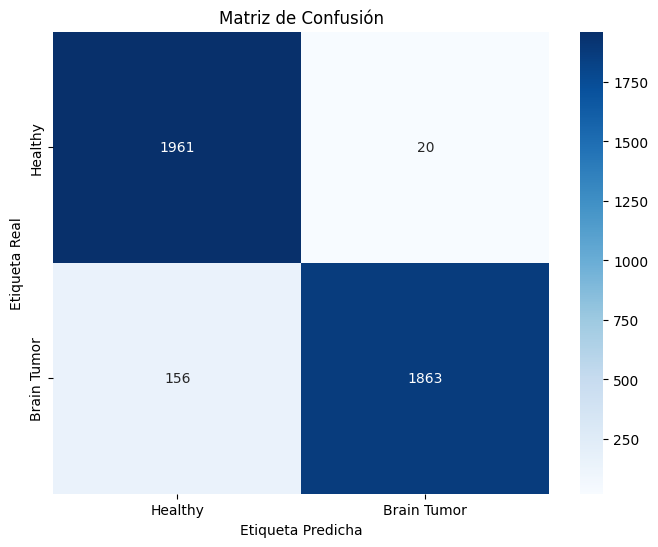

In [19]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Brain Tumor'], yticklabels=['Healthy', 'Brain Tumor'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

In [20]:
# Obtener aquellas filas donde las etiquetas predichas no coinciden con las reales
incorrect_predictions = results[results['Etiqueta Actual'] != results['Etiqueta Predicha']]

# Mostrar el DataFrame con predicciones incorrectas
incorrect_predictions

,Etiqueta Actual,Etiqueta Predicha
28,Healthy,Tumor
48,Healthy,Tumor
84,Healthy,Tumor
85,Healthy,Tumor
93,Tumor,Healthy
...,...,...
3915,Tumor,Healthy
3930,Tumor,Healthy
3940,Tumor,Healthy
3960,Tumor,Healthy


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
# Generar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=['Healthy', 'Tumor'])
print(report)

              precision    recall  f1-score   support

     Healthy       0.93      0.99      0.96      1981
       Tumor       0.99      0.92      0.95      2019

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



# **PREDICIÓN**

In [56]:
# Rutas de las imágenes
image_paths = [
    '/content/PRUEBA MEN.png',
    '/content/PRUEBA CANCER O NO 2.png',
    '/content/PRUEBA CANCER O NO.png'
]

In [57]:
def prepare_image(image_path):
    """Prepara una imagen para ser evaluada por el modelo CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (64, 64))  # Redimensiona la imagen a 64x64
        img = img / 255.0  # Normaliza los valores de los píxeles
        img = np.expand_dims(img, axis=-1)  # Añade una dimensión de canal
        img = np.repeat(img, 3, axis=-1)  # Replicar el canal en 3
        img = np.expand_dims(img, axis=0)  # Añade una dimensión de lote
        return img
    else:
        return None

In [58]:
def predict_tumor_with_prob_model(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model2.predict(img)
        probability = prediction[0][0]
        return ("Tumor", probability) if probability > 0.5 else ("Healthy", 1 - probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)


1/1 [==============================] - 0s 16ms/step


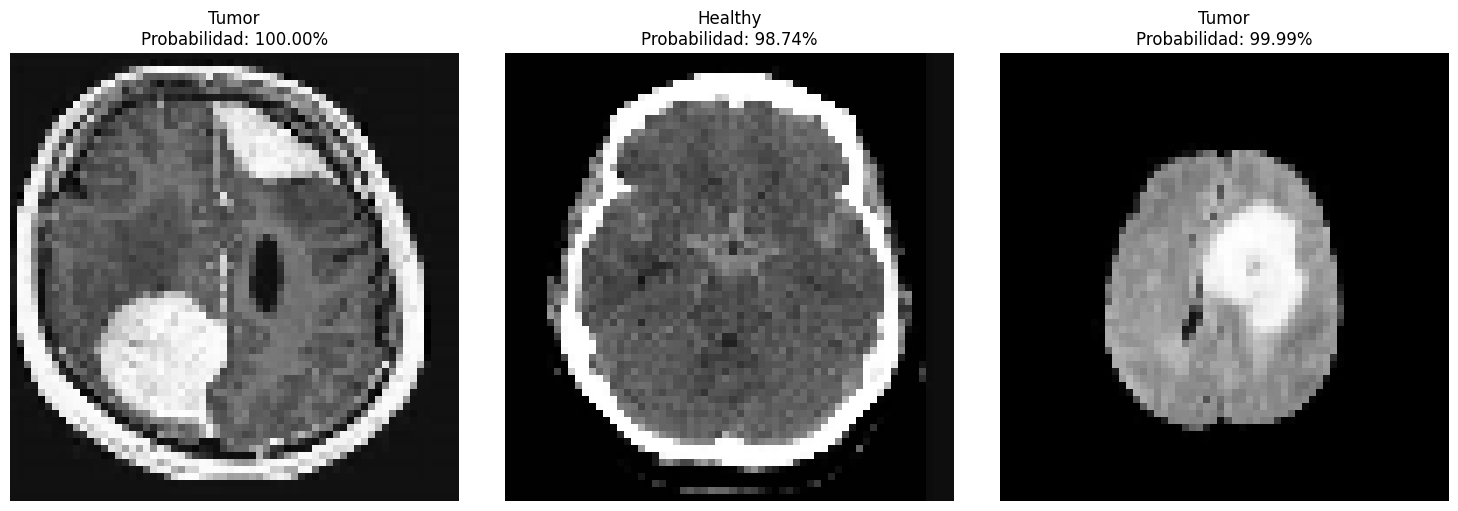

In [59]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model(image_path, model2)
    if label != "La imagen no se encontró o no pudo leerse":
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f'{label}\nProbabilidad: {prob:.2%}')
    else:
        ax.imshow(np.zeros((64, 64)), cmap='gray')
        ax.title.set_text(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

# **Visualización de Grad-CAM**

Para visualizar qué partes de la imagen están influyendo más en las decisiones del modelo

In [76]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
# Función para obtener el mapa de calor Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [77]:
# Función para superponer el mapa de calor en la imagen original
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.nan_to_num(heatmap)  # Reemplazar NaNs por 0 para evitar errores
    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")  # Actualizado según la advertencia de deprecación

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 47ms/step


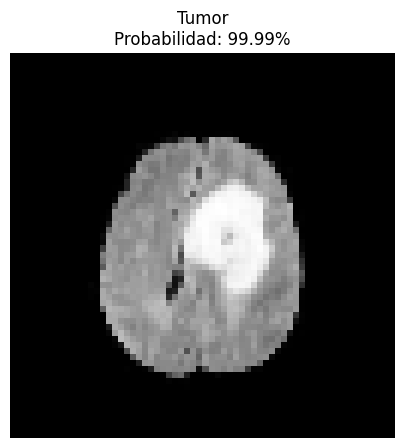

<ipython-input-77-72a9bd078a26>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")  # Actualizado según la advertencia de deprecación


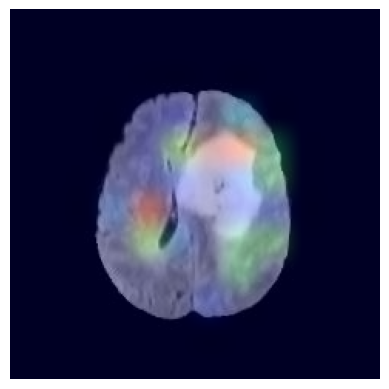

In [78]:
# Imagen objetivo
image_path = '/content/PRUEBA CANCER O NO.png'

# Predecir y mostrar Grad-CAM
label, prob = predict_tumor_with_prob_model(image_path, model2)
if label != "La imagen no se encontró o no pudo leerse":
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))

    # Mostrar la imagen original
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title(f'{label}\nProbabilidad: {prob:.2%}')
    plt.axis('off')
    plt.show()

    # Preparar la imagen para Grad-CAM
    img_array = prepare_image(image_path)
    heatmap = make_gradcam_heatmap(img_array, model2, last_conv_layer_name="conv2d_2")

    # Superponer y mostrar Grad-CAM
    save_and_display_gradcam(image_path, heatmap, cam_path="gradcam.jpg")
else:
    plt.imshow(np.zeros((64, 64)), cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()

# **ALGORITMO DE EXPECTATION MAXIMIZATION**

In [88]:
# Revisar las formas de X_train y X_test
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)


Forma de X_train: (16000, 64, 64, 3)
Forma de X_test: (4000, 64, 64, 3)


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix


# Si es necesario, aplanar las dimensiones extra
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Crear y ajustar el modelo GMM con los datos aplanados
gmm = GaussianMixture(n_components=2, covariance_type='tied', random_state=42)
gmm.fit(X_train_flat)

# Predecir las etiquetas en los conjuntos de entrenamiento y prueba
train_preds = gmm.predict(X_train)
test_preds = gmm.predict(X_test)

# Ajustar las etiquetas predichas
if np.sum(train_preds == y_train) < len(y_train) / 2:
    train_preds = 1 - train_preds
    test_preds = 1 - test_preds

# Calcular la exactitud
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, test_preds)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()